In [1]:
import sys
import uproot
import numpy as np
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import mplhep as hep
from distutils.dir_util import copy_tree
import yahist
from yahist import Hist1D
import torch
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
sys.path.append("/home/zhouy2/vbs/abcdnet/python")
sys.path.append("/home/zhouy2/vbs/abcdnet/scripts/")
sys.path.append("/home/zhouy2/vbs/abcdnet/python/singledisco")
sys.path.append("/home/zhouy2/Analysis/tools")

In [3]:
import ingress
import train
from utils import VBSConfig, VBSOutput
from datasets import DisCoDataset
import plotsUtil
import models

In [13]:
def plotConfig(basedir,choice,is_single_disCo):
    run=os.path.join(basedir,choice)
    # configure everything for reading and plotting
    config_path=glob.glob(run+"/*config.json")[0]
    config=VBSConfig.from_json(config_path)
    with open(config_path) as json_file:
        data = json.load(json_file)
    config.name=data["name"]

    # select history json file
    history_file = train.get_outfile(config, tag="history", ext="json")
    print(history_file)
    with open(history_file) as f:
        history=json.load(f)
    print(history.keys())

    # get train and test data as pt files
    input_dir=os.path.join(run,"inputs")
    print(os.listdir(input_dir))
    data_dir=os.path.join(run,"datasets")
    train_data=ingress.get_outfile(config, tag="train", subdir="inputs", msg=None)
    test_data=ingress.get_outfile(config, tag="test", subdir="inputs", msg=None)
    
    # plot loss history
    plotsUtil.plotHistory(history)
    
    # load all csv files
    csv_name = train.get_outfile(config, epoch=50, tag="REPLACE_inferences", ext="csv", subdir="inferences")
    test_df=pd.read_csv(csv_name.replace("REPLACE", "test"))
    train_df=pd.read_csv(csv_name.replace("REPLACE",'train'))
    
    
    # plot ROC curve
    if (is_single_disCo):
        truth_arr=test_df['truth']
        pred_arr=test_df['score']
        fpr, tpr, thresholds = roc_curve(truth_arr, pred_arr)
        auc = roc_auc_score(truth_arr, pred_arr)
        fig = plt.figure(figsize=(10, 8))
        plt.plot(fpr,tpr,label="AUC="+str(auc), linewidth=4, color='darkorange')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc=4)
        plt.show()
    else:
        truth_arr=test_df['truth']
        pred_arr1=test_df['score1']
        pred_arr2=test_df['score2']
        fpr1, tpr1, thresholds1 = roc_curve(truth_arr, pred_arr1)
        fpr2, tpr2, thresholds2 = roc_curve(truth_arr, pred_arr2)
        auc1 = roc_auc_score(truth_arr, pred_arr1)
        auc2 = roc_auc_score(truth_arr, pred_arr2)
        plt.figure()
        plt.plot(fpr1,tpr1,label="AUC1="+str(auc1))
        plt.plot(fpr2,tpr2,label="AUC2="+str(auc2))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()

In [14]:
# where all trainings are stored
basedir="/blue/p.chang/zhouy2"
print (os.listdir(basedir))

['ABCDNet_2DisCo_noPresel', 'ABCDNet_5DisCo_noPresel', 'ABCDNet_10DoubleDisCo_noPresel', 'data', 'ABCDNet_5DoubleDisCo_noPresel']


/blue/p.chang/zhouy2/ABCDNet_5DoubleDisCo_noPresel/ABCDNet_5DoubleDisCo_noPresel_modelNeuralNetwork_nhidden4_hiddensize128_lrConstantLR0.001_discolambda10_history.json
dict_keys(['train_loss', 'train_bce', 'train_disco', 'test_loss', 'test_bce', 'test_disco', 'slurm_id'])
['ABCDNet_5DoubleDisCo_noPresel_train.pt', 'ABCDNet_5DoubleDisCo_noPresel_test.pt']


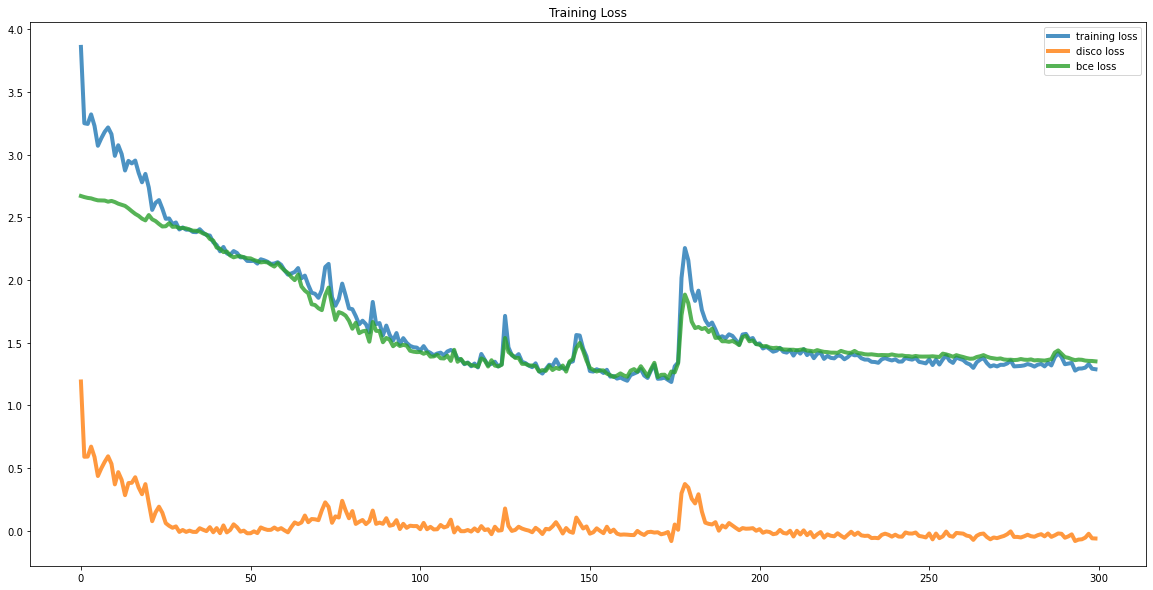

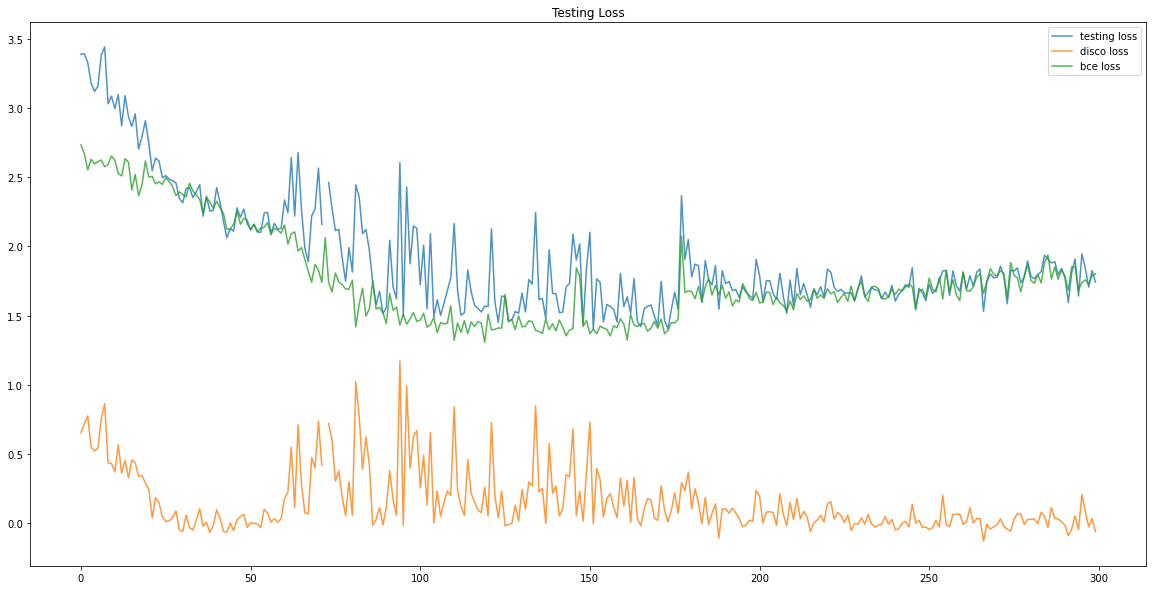

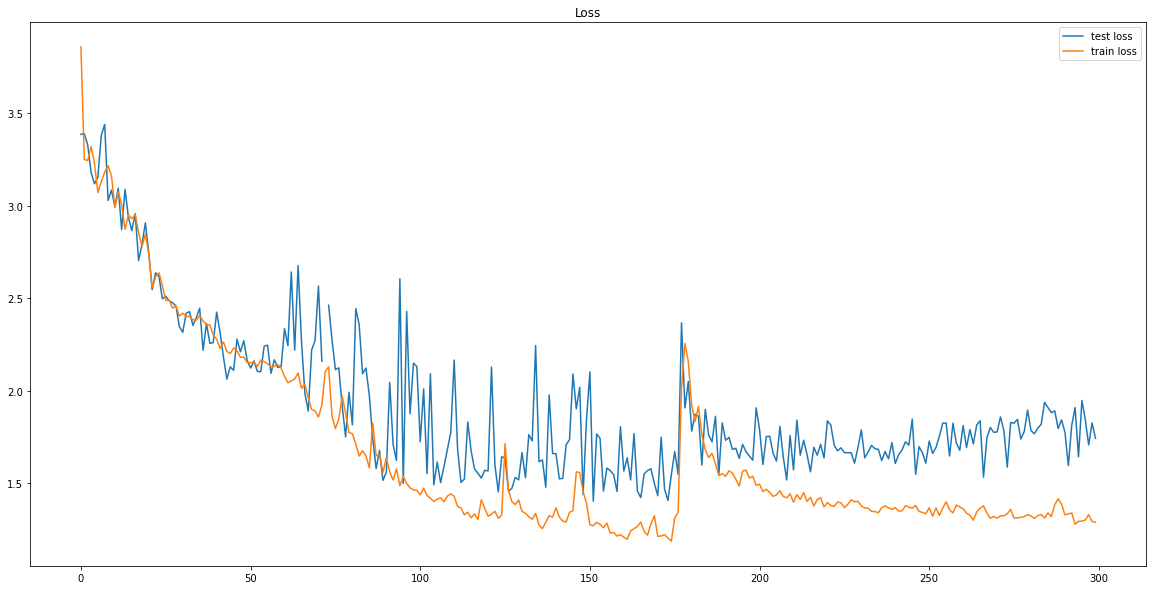

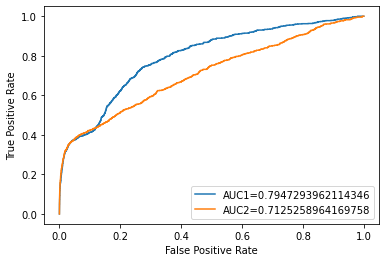

In [15]:
plotConfig(basedir,'ABCDNet_5DoubleDisCo_noPresel', False)

In [327]:
# generate baseline distance correlation loss
bkg_dataset=DisCoDataset.from_file(train_data)
disco_target=bkg_dataset.disco_target
weights=bkg_dataset.disco_target
labels=bkg_dataset.labels
bkg_disco_target=disco_target[labels==0][0:1]
bkg_weights=weights[labels==0][0:1]
score=torch.rand(bkg_disco_target.size(dim=0))

In [328]:
dCorr(bkg_disco_target,score,bkg_weights)

tensor(nan)

In [331]:
def unique(data):
    unique_cols, indexes, counts = np.unique(data.numpy(), axis=1, return_index=True, return_counts=True)
    is_duplicate = np.size(indexes) != np.size(data.numpy(), axis=1)
    num_duplicate_cols = np.max(counts)

    # Print whether or not there are duplicate columns
    if is_duplicate:
        print("There are duplicate columns.")
        print("There are at most", num_duplicate_cols, "duplicate columns.")
    else:
        print("There are no duplicate columns.")
unique(train_data)

There are no duplicate columns.


In [332]:
# load the model at 100 epochs
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_path=train.get_outfile(config, epoch=100, tag="model", subdir="models")
Model=getattr(models, config.model.name)
model=Model.from_config(config).to(device)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

----------------- Neural Network -----------------
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


<All keys matched successfully>

In [333]:
plt.style.use(hep.style.CMS)
plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

In [16]:
# load all csv files
csv_name = train.get_outfile(config, epoch=50, tag="REPLACE_inferences", ext="csv", subdir="inferences")
test_df=pd.read_csv(csv_name.replace("REPLACE", "test"))
train_df=pd.read_csv(csv_name.replace("REPLACE",'train'))

In [17]:
test_df

idx  truth    score1    score2    weight
0          0      1  0.400295  0.026224  0.209057
1          1      1  0.390983  0.958543  0.209057
2          2      1  0.392239  0.305409  0.209057
3          3      1  0.986112  0.725292  0.640773
4          4      1  0.391672  0.620630  0.448780
...      ...    ...       ...       ...       ...
21048  21048      0  0.391803  0.492823  0.034595
21049  21049      0  0.392078  0.010736  0.001518
21050  21050      0  0.391883  0.047185  0.000020
21051  21051      0  0.424356  0.286294  0.001518
21052  21052      0  0.392012  0.112930  0.018802

[21053 rows x 5 columns]

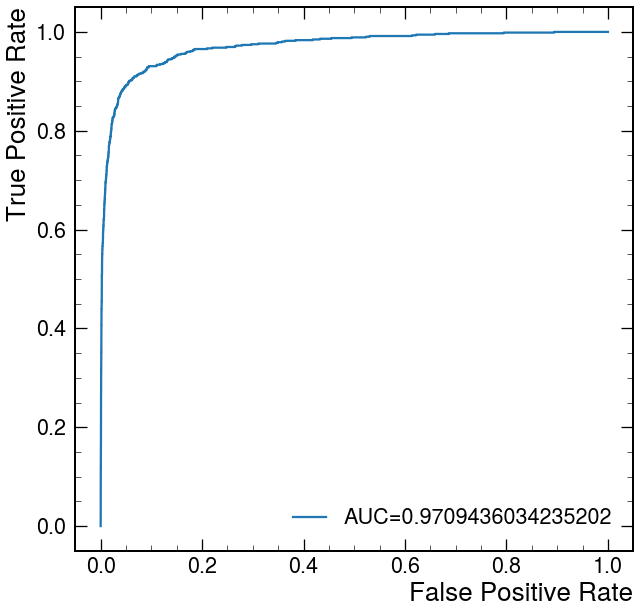

In [336]:
# plot ROC curve
truth_arr=test_df['truth']
pred_arr=test_df['score']
fpr, tpr, thresholds = roc_curve(truth_arr, pred_arr)
auc = roc_auc_score(truth_arr, pred_arr)
plt.figure()
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [337]:
# plot Histogram of inferred score of signal versus background
def getInferScoreHist(infer_name, data_frame, truth_name, weight_name, bins_no, x_range):
    bins_edges=np.linspace(*x_range, bins_no)
    bkg_df=data_frame[data_frame[truth_name]==0]
    sig_df=data_frame[data_frame[truth_name]==1]
    total_bkg_wgt=round(np.sum(bkg_df[weight_name]))
    total_sig_wgt=round(np.sum(sig_df[weight_name]))
    bkg_hist=Hist1D(bkg_df[infer_name], bins=bins_edges, weights=bkg_df[weight_name], label="bkg"+" ("+str(total_bkg_wgt)+")")
    # bkg_hist=Hist1D(bkg_df[infer_name], bins=bins_edges, weights=1, label="bkg"+" ("+str(total_bkg_wgt)+")")
    sig_hist=Hist1D(sig_df[infer_name], bins=bins_edges, weights=sig_df[weight_name], label="sig"+" ("+str(total_sig_wgt)+")")
    # sig_hist=Hist1D(sig_df[infer_name], bins=bins_edges, weights=1, label="sig"+" ("+str(total_sig_wgt)+")")
    
    fig, axes=plt.subplots()
    hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=axes)
    axes.set_xlabel("Single DisCo NN Score")
    axes.set_ylabel("count")
    bkg_hist.plot(ax=axes,alpha=1)
    sig_hist.plot(ax=axes,alpha=1)

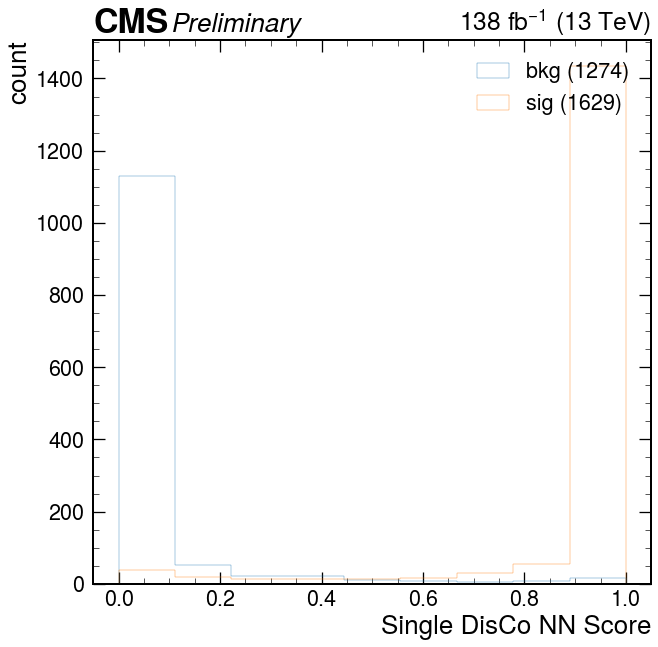

In [338]:
getInferScoreHist('score',pd.concat([test_df,train_df]),'truth','weight',10,(0,1))

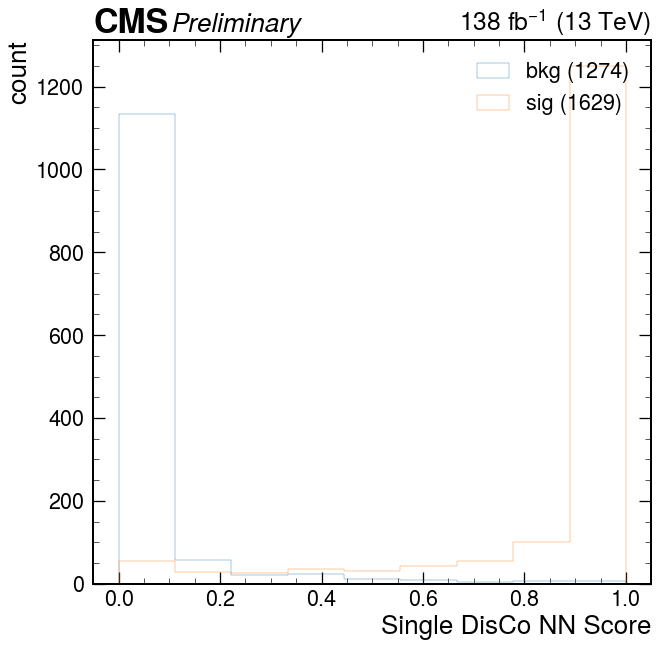

In [339]:
# load new baby roots
new_bkg_baby = f"{config.ingress.input_dir}/{config.name}/bkg_abcdnet.root"
new_sig_baby = f"{config.ingress.input_dir}/{config.name}/signal_abcdnet.root"

# uproot load babies
new_sig_df=uproot.open(new_sig_baby+":tree").arrays(library='pd')
new_sig_df['is_signal']=True
new_bkg_df=uproot.open(new_bkg_baby+":tree").arrays(library='pd')
new_bkg_df['is_signal']=False

# plot inferred score distribution
# this is signal x 1000
getInferScoreHist('abcdnet_score',pd.concat([new_bkg_df,new_sig_df]),'is_signal','xsec_sf',10,(0,1))

In [340]:
# plot distribution in DisCo Target for a certain ABCD cut
def plotDisCoWithCuts(ABCD_cut, NN_score, DisCo_name, df, truth_name, weight_name, x_range, bins_no):
    bins_edges=np.linspace(*x_range, bins_no)
    
    # make cut on ABCD score
    data_frame=df[df[NN_score]>=ABCD_cut]
    
    bkg_df=data_frame[data_frame[truth_name]==0]
    sig_df=data_frame[data_frame[truth_name]==1]
    total_bkg_wgt=round(np.sum(bkg_df[weight_name]))
    total_sig_wgt=round(np.sum(sig_df[weight_name]))/1000
    
    df_list=[bkg_df[DisCo_name],sig_df[DisCo_name]]
    weight_list=[bkg_df[weight_name],sig_df[weight_name]/100]
    label_list=[fr'bkg({total_bkg_wgt})', fr'sig$\times$10({total_sig_wgt})']
    
    fig, axes=plt.subplots()
    hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=axes)
    plt.hist(df_list, stacked=True, alpha=0.6, bins=bins_no, label=label_list, weights=weight_list)
    axes.legend()
    axes.set_xlabel(r"$\Delta \eta_{jj}$")
    axes.set_ylabel("count")

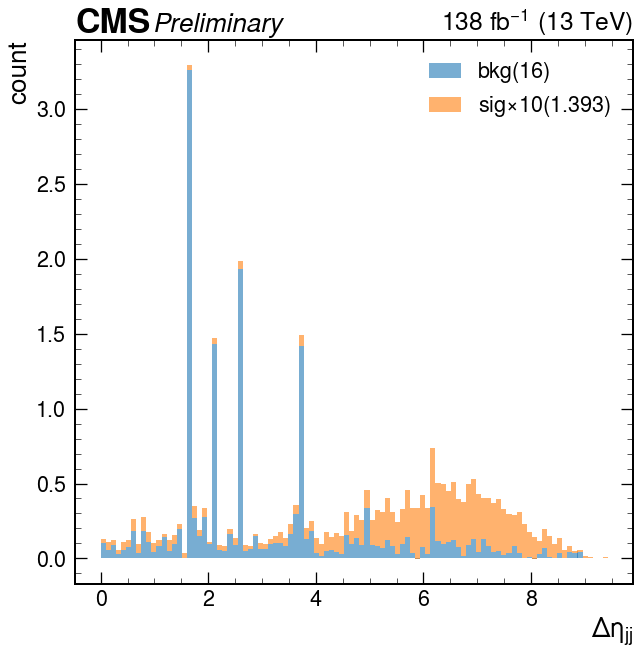

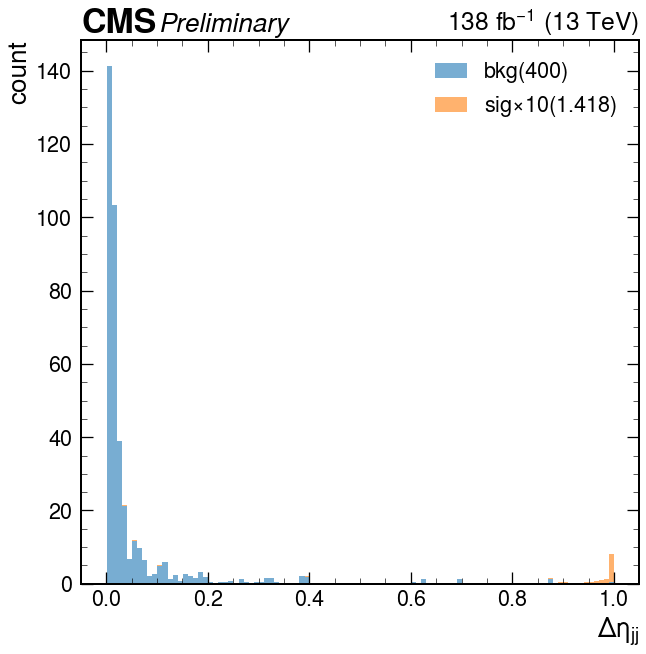

In [341]:
all_df=pd.concat([new_bkg_df,new_sig_df])
plotDisCoWithCuts(0.7, 'abcdnet_score', 'detajj', all_df, 'is_signal', 'xsec_sf', (0,10), 100)
plotDisCoWithCuts(3, 'detajj', 'abcdnet_score', all_df, 'is_signal', 'xsec_sf', (0,1), 100)

In [357]:
# calculate a dataframe that stores the background and signal in A+B versus C+D region
def ABCDClosure(df, truth_name, weight_name, ABCD_name, ABCD_range, ABCD_no, DisCo_name, DisCo_range, DisCo_no):
    result=pd.DataFrame(columns=['NN cut', r'$\delta \eta_{jj}$ Cut', 'A', 'B', 'C', 'D', r'Predicted $A_{BKG}$', r'Actual $A_{BKG}$',
                                r'Actual $A_{SIG}$'])
    NN_cuts=np.linspace(*ABCD_range, ABCD_no)
    Disco_cuts=np.linspace(*DisCo_range, DisCo_no)
    sig_df=df[df[truth_name]==1]
    bkg_df=df[df[truth_name]==0]
    total_sig=np.sum(sig_df[weight_name])/1000
    total_bkg=round(np.sum(bkg_df[weight_name]))
    total_wgt=total_sig+total_bkg
    i=0
    for NNcut in NN_cuts:
        for Discocut in Disco_cuts:
            A_sig_wgt=np.sum(sig_df[(sig_df[ABCD_name]>=NNcut) & (sig_df[DisCo_name]>=Discocut)][weight_name])/1000
            A_bkg_wgt=np.sum(bkg_df[(bkg_df[ABCD_name]>=NNcut) & (bkg_df[DisCo_name]>=Discocut)][weight_name])
            A=A_sig_wgt+A_bkg_wgt
            B_sig_wgt=np.sum(sig_df[(sig_df[ABCD_name]>=NNcut) & (sig_df[DisCo_name]<Discocut)][weight_name])/1000
            B_bkg_wgt=np.sum(bkg_df[(bkg_df[ABCD_name]>=NNcut) & (bkg_df[DisCo_name]<Discocut)][weight_name])
            B=B_sig_wgt+B_bkg_wgt
            C_sig_wgt=np.sum(sig_df[(sig_df[ABCD_name]<NNcut) & (sig_df[DisCo_name]>=Discocut)][weight_name])/1000
            C_bkg_wgt=np.sum(bkg_df[(bkg_df[ABCD_name]<NNcut) & (bkg_df[DisCo_name]>=Discocut)][weight_name])
            C=C_sig_wgt+C_bkg_wgt
            D_sig_wgt=np.sum(sig_df[(sig_df[ABCD_name]<NNcut) & (sig_df[DisCo_name]<Discocut)][weight_name])/1000
            D_bkg_wgt=np.sum(bkg_df[(bkg_df[ABCD_name]<NNcut) & (bkg_df[DisCo_name]<Discocut)][weight_name])
            D=D_sig_wgt+D_bkg_wgt
            result.loc[i]=[NNcut, Discocut, A,  B, C, D, B*C/D, A_bkg_wgt, A_sig_wgt]
            i+=1
    return result

In [369]:
Closure_df=ABCDClosure(all_df, 'is_signal', 'xsec_sf', 'abcdnet_score', (0.5,0.9), 20, 'detajj', (3,5), 6)

In [371]:
Closure_df.loc[100:]

NN cut  $\delta \eta_{jj}$ Cut         A         B           C  \
100  0.836842                     4.6  3.490175  7.247000  116.478623   
101  0.836842                     5.0  2.949877  7.787299   82.032060   
102  0.857895                     3.0  5.328265  4.910890  396.196581   
103  0.857895                     3.4  5.153111  5.086045  307.398603   
104  0.857895                     3.8  3.657880  6.581276  226.192527   
105  0.857895                     4.2  3.406653  6.832503  161.404947   
106  0.857895                     4.6  3.325420  6.913735  116.643378   
107  0.857895                     5.0  2.808340  7.430816   82.173598   
108  0.878947                     3.0  3.785949  4.736121  397.738897   
109  0.878947                     3.4  3.628206  4.893863  308.923508   
110  0.878947                     3.8  3.447668  5.074401  226.402739   
111  0.878947                     4.2  3.210882  5.311187  161.600718   
112  0.878947                     4.6  3.134656  5.387413  116.834143   
113  0.878947                     5.0  2.658100  5.863969   82.323837   
114  0.900000                     3.0  3.254417  4.563073  398.270429   
115  0.900000                     3.4  3.094673  4.722817  309.457041   
116  0.900000                     3.8  2.912422  4.905068  226.937985   
117  0.900000                     4.2  2.714030  5.103461  162.097570   
118  0.900000                     4.6  2.645927  5.171563  117.322872   
119  0.900000                     5.0  2.278706  5.538784   82.703231   

               D  Predicted $A_{BKG}$  Actual $A_{BKG}$  Actual $A_{SIG}$  
100  1148.636680             0.734889          2.425543          1.064633  
101  1183.083243             0.539952          1.937441          1.012436  
102   869.416742             2.237912          4.172005          1.156260  
103   958.214720             1.631621          4.012113          1.140997  
104  1039.420796             1.432178          2.535897          1.121984  
105  1104.208375             0.998724          2.312623          1.094030  
106  1148.969944             0.701882          2.275934          1.049486  
107  1183.439725             0.515968          1.809179          0.999161  
108   869.591512             2.166235          2.643791          1.142158  
109   958.406902             1.577440          2.501311          1.126895  
110  1040.927671             1.103687          2.338702          1.108967  
111  1105.729692             0.776222          2.129543          1.081340  
112  1150.496267             0.547098          2.096729          1.037928  
113  1185.006572             0.407377          1.669293          0.988807  
114   869.764559             2.089459          2.137174          1.117243  
115   958.577948             1.524664          1.989601          1.105072  
116  1041.097003             1.069205          1.825069          1.087353  
117  1105.937418             0.748016          1.653913          1.060117  
118  1150.712117             0.527276          1.628687          1.017241  
119  1185.331757             0.386453          1.308433          0.970273

In [ ]:
# explore different ABCD cuts

In [15]:
#plots_dir=f"{config.basedir}/{config.name}/plots/lambda{config.train.disco_lambda}_scatter"
#os.makedirs(plots_dir,exist_ok=True)

In [102]:
label_dict={
    'hbb_pt': r'$p_T(H\to bb)$',
    'hbb_eta': r'$\eta(H\to bb)$',
    'hbb_phi': r'$\phi(H\to bb)$',
    'hbb_mass': r'$M(H\to bb)$',
    'ld_vbfjet_phi': r'$\phi(VBF_{ld})$',
    'ld_vbfjet_mass': r'$M(VBF_{ld})$',
    'ld_vbfjet_eta': r'$\eta(VBF_{ld})$',
    'ld_vbfjet_pt': r'$p_T(VBF_{ld})$',
    'sd_vbfjet_phi': r'$\phi(VBF_{sd})$',
    'sd_vbfjet_mass': r'$M(VBF_{sd})$',
    'sd_vbfjet_eta': r'$\eta(VBF_{sd})$',
    'sd_vbfjet_pt': r'$p_T(VBF_{sd})$',
    'ld_lep_phi':r'$\phi(lep_{ld})$',
    'ld_lep_eta':r'$\eta(lep_{ld})$',
    'ld_lep_mass':r'$M(lep_{ld})$',
    'ld_lep_pt':r'$p_T(lep_{ld})$',
    'sd_lep_phi':r'$\phi(lep_{sd})$',
    'sd_lep_eta':r'$\eta(lep_{sd})$',
    'sd_lep_mass':r'$M(lep_{sd})$',
    'sd_lep_pt':r'$p_T(lep_{sd})$',
    'mjj':r'$M_{jj}$',
    'detajj':r'$\Delta \eta_{jj}$'
}

/tmp/ipykernel_2881553/82053257.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


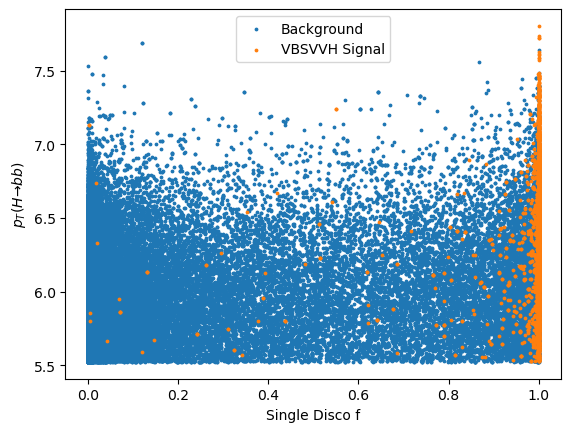

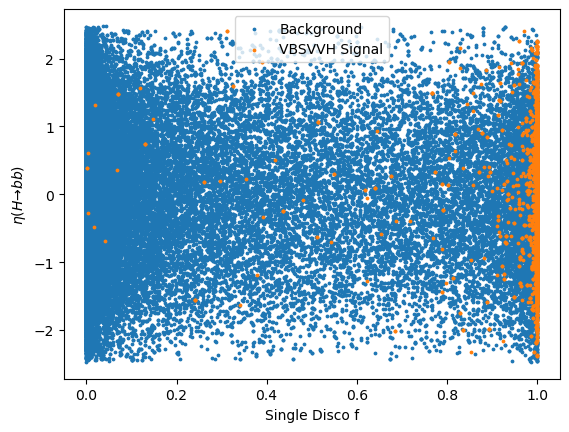

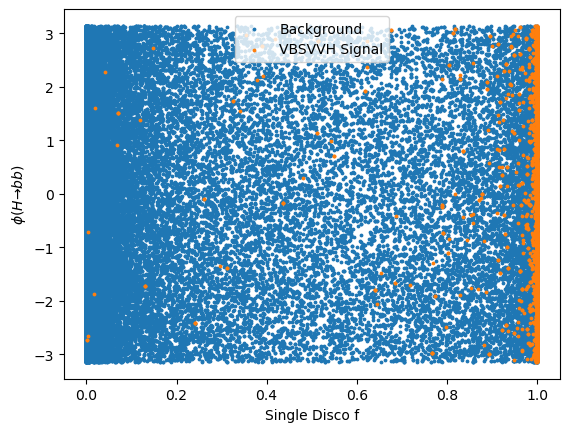

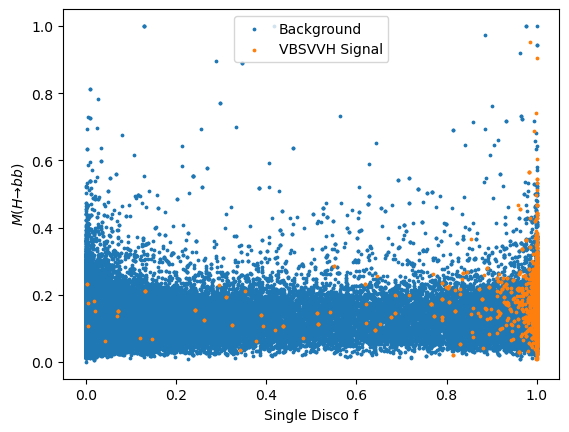

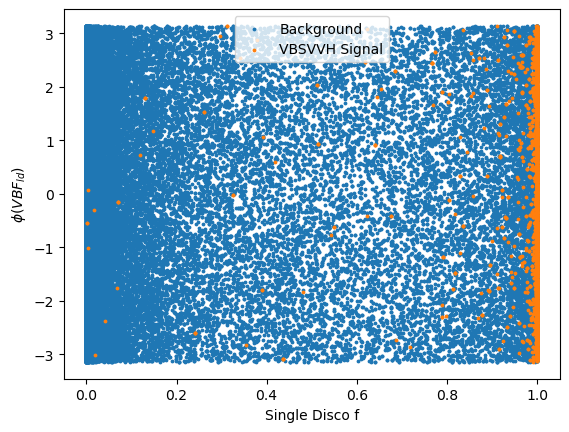

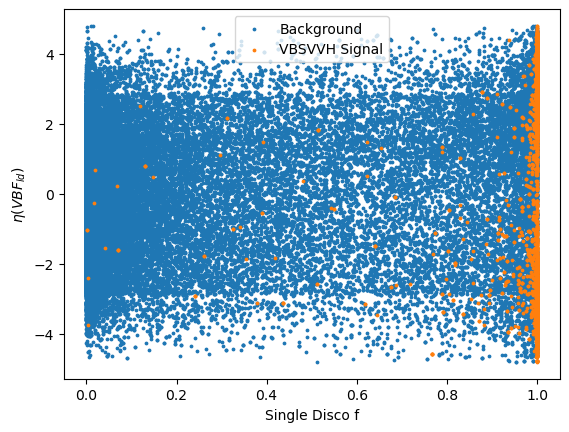

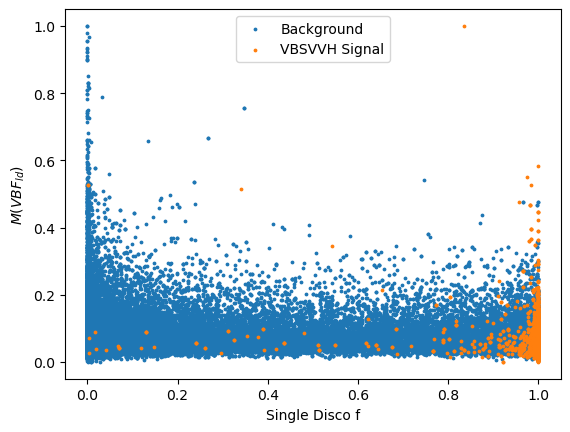

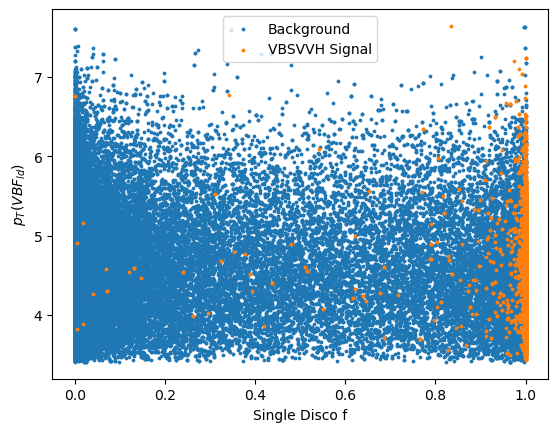

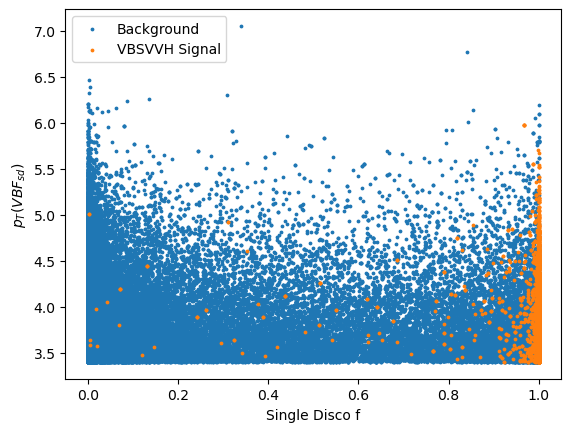

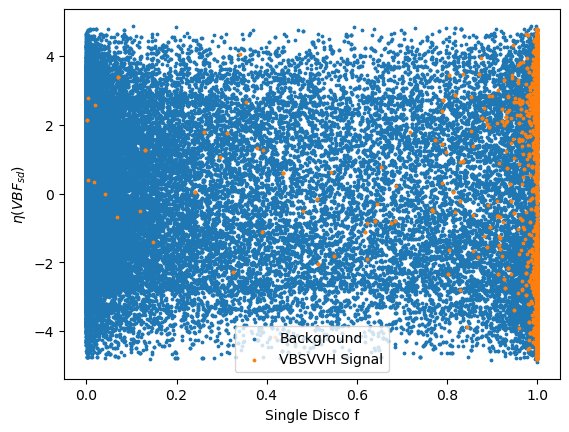

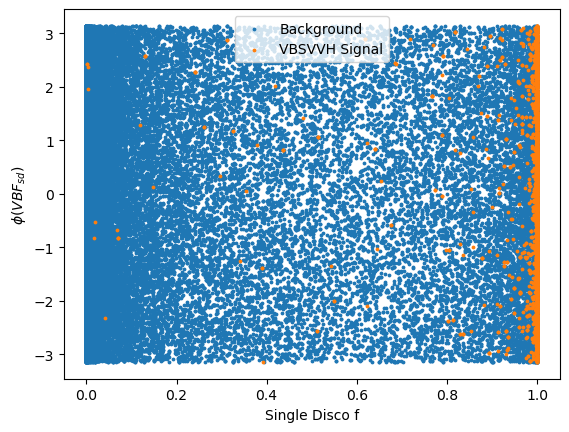

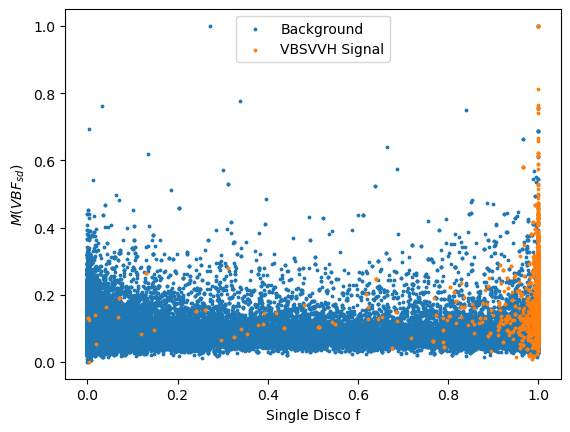

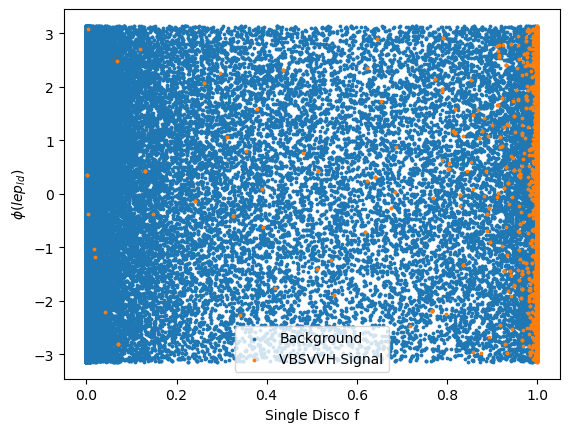

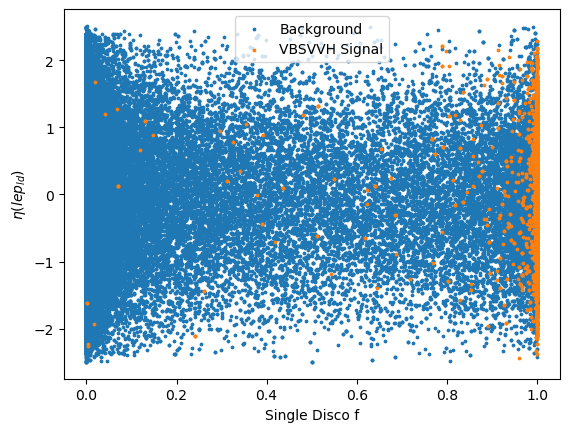

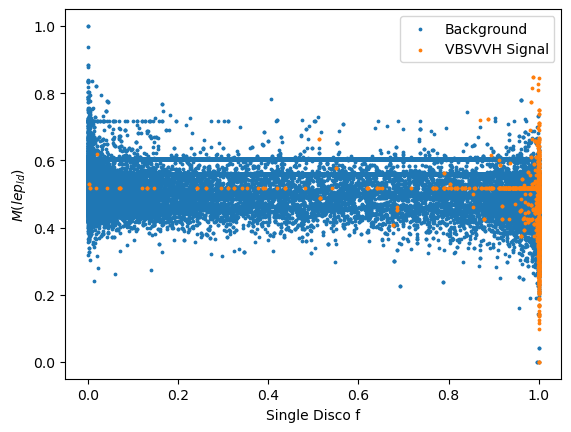

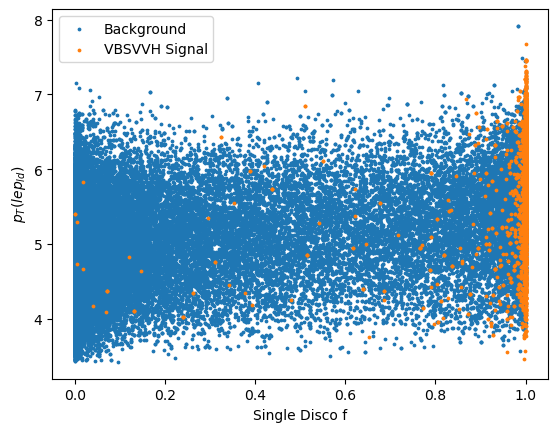

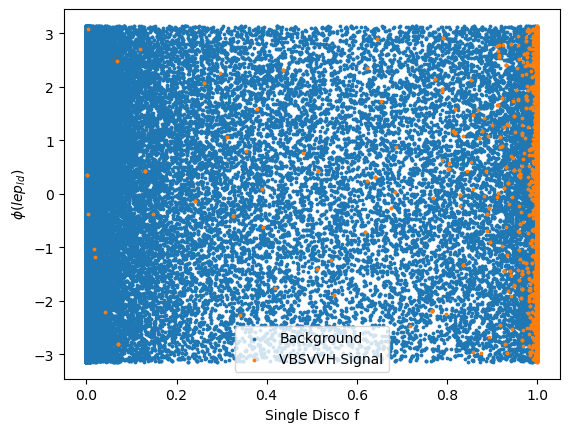

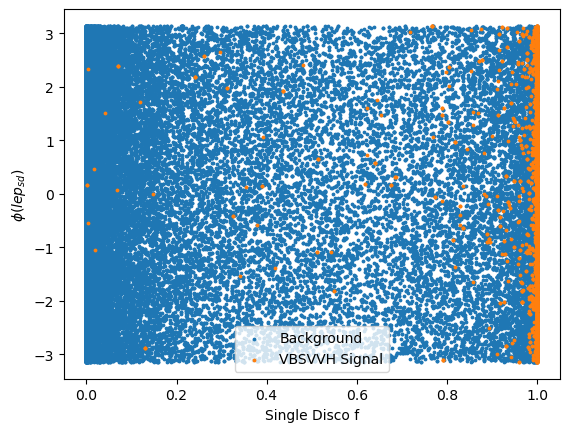

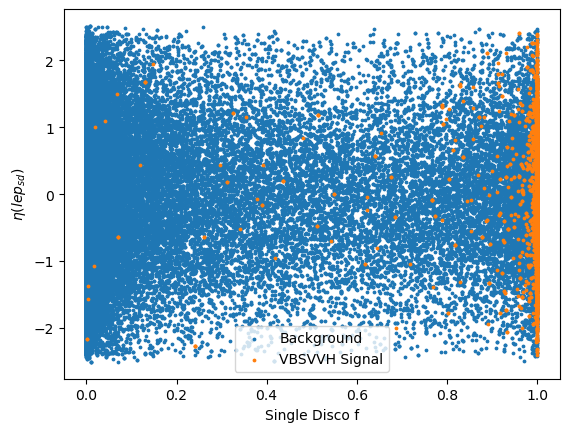

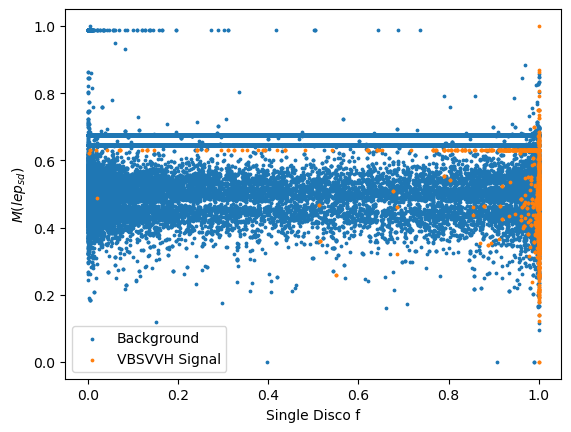

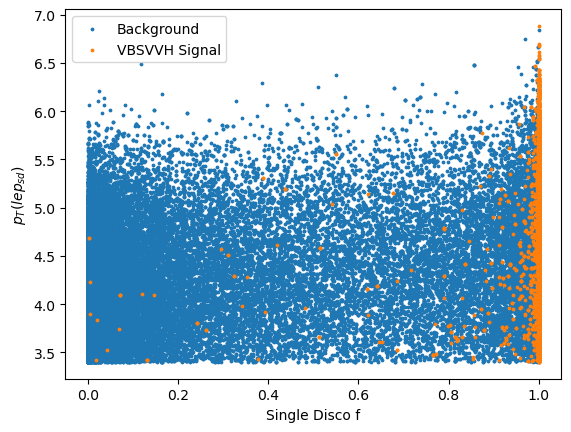

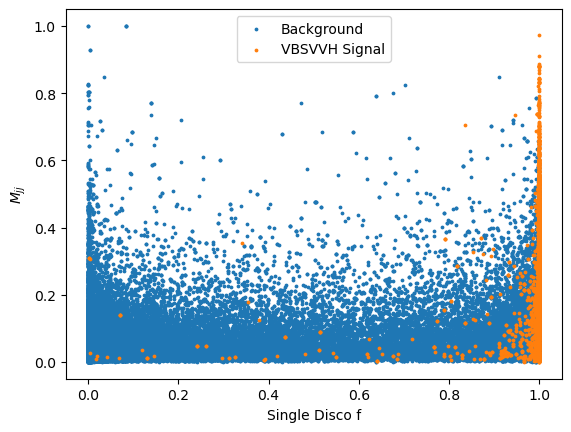

In [17]:
# scatter plots of classifiers versus input features for background and signal separately
plt.figure()
plt.scatter(test_df[test_df['']][true_labels==0], inputs[:,idx][true_labels==0], s=3, label='Background')
plt.scatter(predicted_scores[:,0][true_labels==1], inputs[:,idx][true_labels==1], s=3, label='VBSVVH Signal')
plt.xlabel('Single Disco f')
if name in label_dict: 
    plt.ylabel(label_dict[name])
else:
    plt.ylabel(name)
plt.legend()
plt.show()
# plt.savefig(f'{plots_dir}/disco{config.train.disco_lambda}_{name}.png')

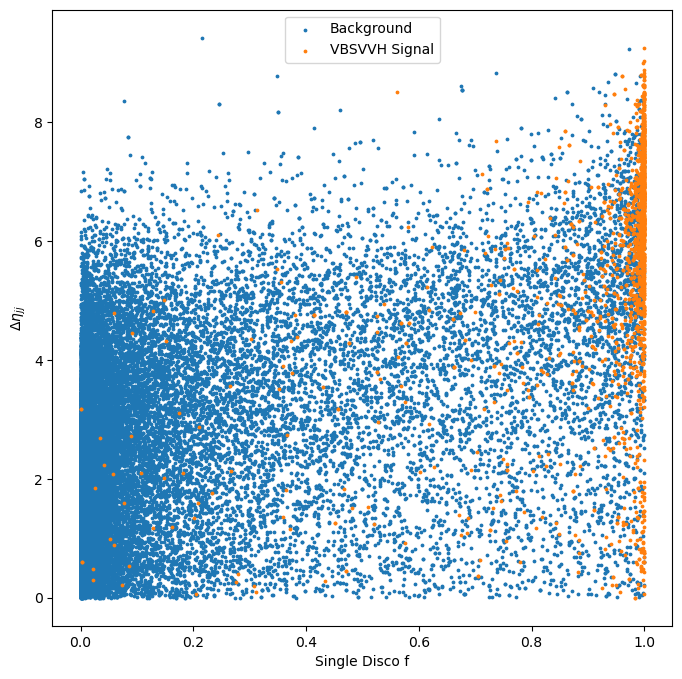

In [ ]:
disco_name=config.ingress.disco_target
plt.figure(figsize=(8,8))
plt.scatter(predicted_scores[:,0][true_labels==0], target[true_labels==0], s=3, label='Background')
plt.scatter(predicted_scores[:,0][true_labels==1], target[true_labels==1], s=3, label='VBSVVH Signal')
plt.xlabel('Single Disco f')
if disco_name in label_dict: 
    plt.ylabel(label_dict[disco_name])
else:
    plt.ylabel(disco_name)
plt.legend()
plt.savefig(f'{plots_dir}/lambda{config.train.disco_lambda}_{disco_name}.png')

<Axes: >

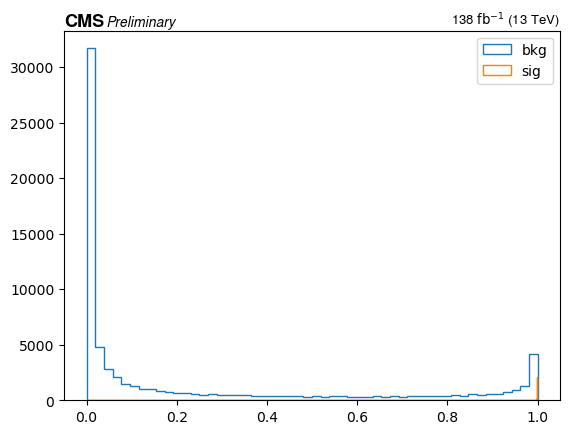

In [22]:
fig, axes=plt.subplots()
hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=axes)
bkg_hist=Hist1D(predicted_scores[:,0][true_labels==0], label="bkg")
sig_hist=Hist1D(predicted_scores[:,0][true_labels==1], label='sig')
bkg_hist.plot()
sig_hist.plot()

In [ ]:
public_html_dir="/home/users/joytzphysics/public_html/abcdnet"
os.makedirs(f'{public_html_dir}/VBSVVH/lambda{config.train.disco_lambda}/scatter_plots',exist_ok=True)

In [ ]:
import shutil
shutil.copytree(plots_dir,f'{public_html_dir}/VBSVVH/lambda{config.train.disco_lambda}/scatter_plots', dirs_exist_ok=True)

'/home/users/joytzphysics/public_html/abcdnet/VBSVVH/scatter_plots'

In [20]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)

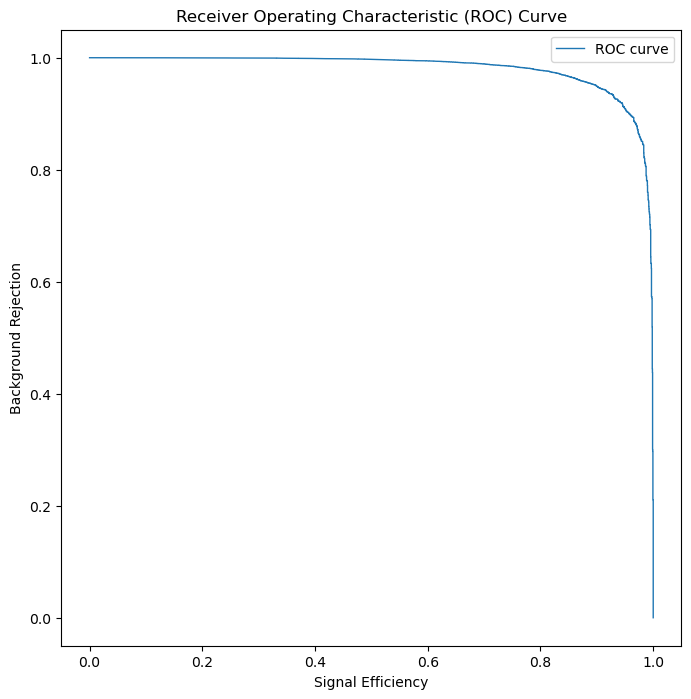

In [21]:
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(8, 8))
plt.plot(tpr, 1-fpr, lw=1, label='ROC curve')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [ ]:
roc_auc

0.8735077795578413